In [200]:
# Step 1

class Multinomial_NB: 
    
    def _init_(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, Y):
        self.row, self.column = X.shape
        self.c, self.cCount = np.unique(Y, return_counts=True)
        numberOfClass = len(self.c)    
        numberTerms = len(np.unique(X[:, 2]))

        # Find prior
        self.prior = np.zeros(numberOfClass)
        for i, c in enumerate(self.c):
            numberSample = X[np.where(Y == c)]
            self.prior[i] = ((numberSample.shape[0] + self.alpha) / (numberOfClass * self.alpha + self.row))

        # Find likelihood
        self.likelihood = {i:{} for i in range(self.column)}
        for j in range(self.column):
            for c in range(numberOfClass):
                feature, featureCounts = np.unique(X[np.where(Y == c), j], return_counts=True)
                probabilityArray = (featureCounts + self.alpha) / (numberTerms * self.alpha + self.cCount[c])
                dictionary = {feature[k]: probabilityArray[k] for k in range(len(feature))}
                dictionary['NotExist'] = self.alpha/(numberTerms * self.alpha + self.cCount[c])
                self.likelihood[j][self.c[c]] = dictionary
              
    def predict(self, X):
        posterior = []
        row, column = X.shape
        
        log_posterior = self.predict_log_proba(X)
        
        for i in range(row):
            maximum = float('-inf')
            label = None
            for j in range(len(self.prior)):
                if log_posterior[i][j] > maximum:
                    maximum = log_posterior[i][j]
                    label = j
            posterior.append(label)
        
        return posterior
                
    def predict_log_proba(self, X): 
        row, column = X.shape
        posteriors = np.zeros((row, len(self.prior)))

        for i in range(row):
            for j in range(len(self.prior)):
                prior = self.prior[j]
                normalize = 1
                for k in range(column):
                    status = self.likelihood[k][j].get(X[i, k])
                    # if status is NONE
                    if status:
                        normalize *= status
                    else:
                        normalize *= self.likelihood[k][j]['NotExist']
                posteriors[i][j] = prior * normalize
        return np.log2(posteriors)

    def predict_proba(self, X):
        return pow(2, self.predict_log_proba(X))

In [133]:
# Step 2

import pandas as pd

df = pd.read_csv('SMSSpamCollection', sep='\t', names=['label','sms_message'])
df.head()

,label,sms_message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [134]:
# Step 3

df['length'] = df['sms_message'].map(lambda text: len(text))

df.groupby('label').length.describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


In [135]:
# Step 3

df['label'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,sms_message,length
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


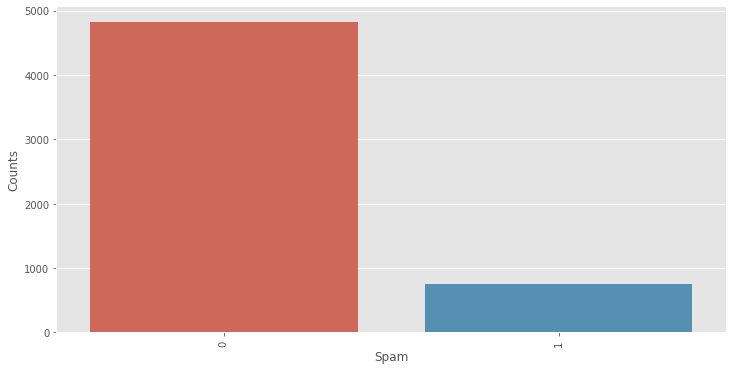

In [136]:
# Step 4
# 0 ham, 1 spam

import seaborn as sns
import matplotlib.pyplot as plt
 
label_counts = df.label.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('Spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()

In [21]:
#Step 5

In [137]:
%%time
# import ssl
# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['sms_message'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1124)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1124)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1124)>


CPU times: user 1.67 s, sys: 27 ms, total: 1.7 s
Wall time: 2.3 s


In [138]:
print(df['sms_message'][2])
print("\nLemmatized Email:\n")
print(df['text_lemmatized'][2])

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

Lemmatized Email:

free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive entry question ( std txt rate ) t & c 's apply 08452810075over18 's


In [8]:
#Step 6
from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

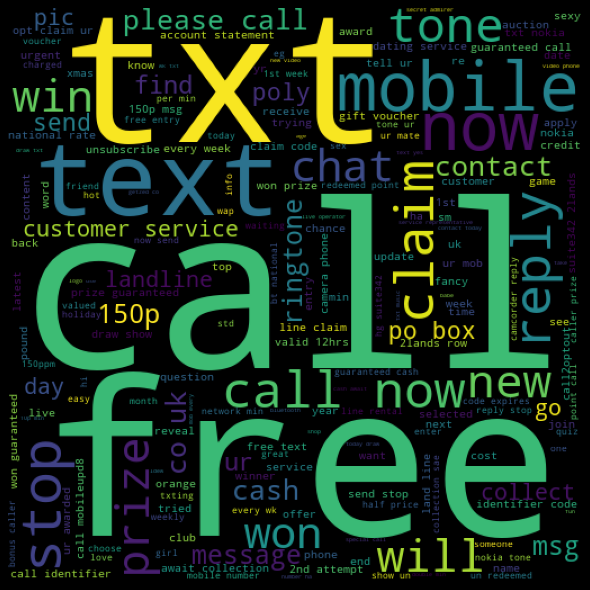

In [81]:
#Step 6

from wordcloud import WordCloud

#for spam messages
spam_words = ''.join(list(df[df['label']==1]['text_lemmatized']))
spam_wordclod = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordclod)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [139]:
# Step 7
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

documents = df['text_lemmatized']

count_vect = CountVectorizer(lowercase=True, stop_words='english')
document_counts = count_vect.fit_transform(documents)

documents = np.array(documents)

# print("\nFeature Names:")
# print(count_vect.get_feature_names())

# print("\nVocabulary: ", count_vect.vocabulary_)


print("\nCount Vector Matrix (Dense Matrix):")
print(document_counts.toarray())

print(document_counts.shape)


Count Vector Matrix (Dense Matrix):
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5572, 7935)


In [140]:
# Step 8

X = df['text_lemmatized']
y = df['label']

print(X.shape)
print(y.shape)

(5572,)
(5572,)


In [141]:
# Step 9
df = df.sample(frac=1) 
df.head()

,label,sms_message,length,text_lemmatized
4219,0,Actually i'm waiting for 2 weeks when they sta...,60,actually i 'm waiting for 2 week when they sta...
2014,1,Great News! Call FREEFONE 08006344447 to claim...,118,great news ! call freefone 08006344447 to clai...
377,0,You could have seen me..i did't recognise you ...,53,you could have seen me .. i did't recognise yo...
366,0,Well i know Z will take care of me. So no worr...,50,well i know z will take care of me . so no wor...
5238,0,Yeah I can still give you a ride,32,yeah i can still give you a ride


In [142]:
#Step 10

# Splitting the data into Train Set and Test Set
def partition(X,y,t):
    x_train = np.array(X[int((len(X)+1)*t):])
    x_test = np.array(X[:int((len(X)+1)*t)])
    y_train = np.array(y[int((len(y)+1)*t):])
    y_test = np.array(y[:int((len(y)+1)*t)]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['label'] #target vector
    X = dataSet.drop(columns='label') #features matrix
    t = 0.2
    return X,y,t

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition


In [146]:
# Functions for Part D

# Returns the Accuracy
def accuracy(predicted, actual):
    accuracy = sum(np.array(predicted) == np.array(actual)) / float(len(actual))
    return accuracy

# Calculates Precision Values when inputs are TP and FP 
# that are based upon the probability and threshold
def precisions(tp, fp):
    score = []
    for i in range(len(tp)):
        precision = tp[i] / (tp[i] + fp[i])
        i += 1
        score.append(precision)
    return score

# Calculates Recall Values when inputs are TP and FN 
# that are based upon the probability and threshold
def recalls(tp, fn):
    score = []
    for i in range(len(tp)):
        recall = tp[i] / (tp[i] + fn[i])
        i += 1
        score.append(recall)
    return score


# Calculates Precision Score when input arguments are Test Labels and the 
# predicted labels
def precisionScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp/(tp+fp)
    return score

# Calculates Recall Score when input arguments are Test Labels and the 
# predicted labels
def recallScore(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    score = tp/(tp+fn)
    return score

# Calculates F1 Score when input arguments are Test Labels and the 
# predicted labels
def f1_score(yTest, yPredict):
    tp = sum((np.array(yTest) == 1) & (np.array(yPredict) == 1))
    fn = sum((np.array(yTest) == 1) & (np.array(yPredict) == 0))
    fp = sum((np.array(yTest) == 0) & (np.array(yPredict) == 1))
    score = tp / (tp + ((fn + fp) / 2))
    return score

# Generates the Confusion Matrix
def confusionMatrix(actual, predicted):
    confusionLists = np.unique(actual)
    matrixSize = len(confusionLists)
    matrix = np.zeros((matrixSize, matrixSize))
    for i in range (matrixSize):
        for j in range (matrixSize):
            matrix[i, j] = np.sum((actual == confusionLists[i]) & (predicted == confusionLists[j]))
    return matrix

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

# Generates the ROC Curve

def roc_curve(yTest, probability, label=None):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
        
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):
        fpr = fpValues[i]/(fpValues[i]+tnValues[i]) #False Positive Rate
        tpr = tpValues[i]/(tpValues[i]+fnValues[i]) #True Positive Rate
        
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)
        
    print(fprList)
    print(tprList)
    
    #Plotting
    fig = plt.figure(figsize=(10, 6))
    plt.plot(fprList, tprList, color='darkorange', linewidth=8, label=label) 
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis([0, 1, 0, 1])
    plt.title('ROC Curve (Train Data)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()


# Generates the AUC values
def AUC(yTest, probability):
    fprList = []
    tprList = []
    
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fpValues = []
    fnValues = []
    tpValues = []
    tnValues = []

    # Getting a new array of predictions based on the thresholds and the
    # array of probabilities of "1: Good Wine" in KNN
    for j in range(len(thresholds)):
        newValues = []
        for i in range(len(probability)):
            if (probability[i] < thresholds[j]):
                newValues.append(0)
            else:
                newValues.append(1)
        for k in range(len(newValues)):
            tp = sum((np.array(yTest) == 1) & (np.array(newValues) == 1))
            fn = sum((np.array(yTest) == 1) & (np.array(newValues) == 0))
            fp = sum((np.array(yTest) == 0) & (np.array(newValues) == 1))
            tn = sum((np.array(yTest) == 0) & (np.array(newValues) == 0))

        tpValues.append(tp)
        fnValues.append(fn)
        fpValues.append(fp)
        tnValues.append(tn)

    for i in range(len(fpValues)):     
        fpr = fpValues[i]/(fpValues[i]+tnValues[i])
        tpr = tpValues[i]/(tpValues[i]+fnValues[i])
        #put point by point into list
        fprList.append(fpr)
        tprList.append(tpr)

    fprList = np.flip(fprList)
    tprList = np.flip(tprList)
    
    auc = np.trapz(tprList, fprList)
    
    return auc

In [144]:
#Step 11

def sFold(folds, data, labels, model, error_function, dictionary): 
    avgF1Score = [] 
    splitX = partitionSplit(data, folds)

    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        del(trainSet[i])       #dropping the validation set
        trainSet = sum(trainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []        
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])

        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using KNN
        if model == 'Multinomial_NB':
            modelClassifier = Multinomial_NB()
            modelClassifier._init_(alpha=dictionary.get('alpha'))
            modelClassifier.fit(np.array(xTrainValues), np.array(yTrainValues))
            yPredict = modelClassifier.predict(np.array(xTestValues))
            accuracy_value = accuracy(yPredict, np.array(yTestValues))
            
            #calculating the error using f1 score
            if error_function == 'f1':
                error = f1_score(np.array(yTestValues), yPredict)
                avgF1Score.append(error)

    #get the average f1 score for the current k
    avgFinalF1Score = sum(avgF1Score) / len(avgF1Score) 
    print(avgFinalF1Score) 
    print('\n')

    return {'expected labels': yTestValues, 'predicted labels': yPredict, 'errors': [error]}

In [198]:
#get the X data(features without target) and y data(target column)
X,y,t = separateTargetVector(df)

#function to pass the hyperparameter into s-fold validation
def dictionary(alpha):
    modelArgs = dict()
    #form the dictionary
    for eachAlpha in alpha:
        modelArgs = {'alpha': eachAlpha}
        #use of s-folds
        out = sFold(5, X, y, 'Multinomial_NB', 'f1', modelArgs)

alpha = [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 1.5, 2.0]

dictionary(alpha)

0.44860858114353874


0.44860858114353874


0.4539196318137506


0.5291123274673072


0.6276595673821458


0.5298094166818681


0.3313469853092953


0.2412999459336393




In [202]:
#Step 12
import numpy as np
X,y,t = separateTargetVector(df)
xTrain, xTest, yTrain, yTest = partition(X, y, t)
modelClassifier = Multinomial_NB()
modelClassifier._init_(alpha=0.5)
modelClassifier.fit(np.array(xTrain), np.array(yTrain))
yPredict = modelClassifier.predict(np.array(xTest))
probability1 = modelClassifier.predict_log_proba(np.array(xTest))
probability2 = modelClassifier.predict_proba(np.array(xTest))
yPredict = np.array(yPredict)

print(probability1)
print(probability2)

# # Plot the ROC Curve
# print("ROC_curve:")
# roc_curve(yTest, probability)
# print("\n")

# # Get the AUC Value
# print("AUC_curve:")
# auc = AUC(yTest, probability)
# print("AUC: %f" %auc)
# print("\n")

[[-35.26182791 -40.05762448]
 [-36.72895392 -34.08034456]
 [-34.70789231 -40.05762448]
 ...
 [-37.35698514 -40.05762448]
 [-33.52179601 -40.05762448]
 [-40.81641676 -40.05762448]]
[[2.42734829e-11 8.73883373e-13]
 [8.77977043e-12 5.50546525e-11]
 [3.56355388e-11 8.73883373e-13]
 ...
 [5.68102792e-12 8.73883373e-13]
 [8.10837622e-11 8.73883373e-13]
 [5.16457084e-13 8.73883373e-13]]


In [203]:
# Step 13

print('Precision:', precisionScore(yTest, yPredict))
print('Recall:', recallScore(yTest, yPredict))
print('F1 score:', f1_score(yTest, yPredict))
print('Accuracy:', accuracy(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

Precision: 0.5054347826086957
Recall: 0.6739130434782609
F1 score: 0.577639751552795
Accuracy: 0.8779174147217235
Confusion Matrix: [[885.  91.]
 [ 45.  93.]]




In [101]:
#Logistic Regression Model
# Step 15

def one_hot_labels(Y):
    class_label = np.unique(Y)
    Y_one_hot = np.zeros((len(Y), len(class_label)))

    for i in range(len(Y)):
        for j in range(len(class_label)):
            if Y[i] == class_label[j]:
                Y_one_hot[i][j] = 1
    
    return Y_one_hot

In [102]:
# Step 16

def softmax(score):
    return np.exp(score)/sum(np.exp(score))

In [103]:
# Step 17

def cross_entropy_loss(Y_one_hot, Y_proba):
    return (Y_one_hot*(-np.log(Y_proba))).sum()

In [104]:
# Step 18

class Softmax_Regression:
    
    def __init__(self):
        pass
    
    def fit(self, X, Y, learning_rate=0.01, epochs=1000, tol=None, regularizer=None, lambd=0.0, early_stopping=False, validation_fraction=0.1, **kwargs):
        self.m, self.col = X.shape
        self.X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)  #add a bias term into features
        self.Y = Y
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.tol = tol
        self.lambd = lambd
        self.previous_cost = 0
        
        class_label = np.unique(self.Y)
        self.Y_one_hot = one_hot_labels(self.Y)
        self.theta = np.zeros((X.shape[1] + 1, len(class_label))) #dimension of theta (d+1), where d is the number of features
        
        for i in range(self.epochs):
            self.Y_proba = softmax(np.dot(self.X, self.theta))
            
            #lasso regression
            if regularizer == "l1": 
                self.lasso_regression()

            #ridge regression    
            elif regularizer == "l2": 
                self.ridge_regression()

            #None    
            else: 
                
                self.gradientVector = (self.learning_rate/self.m) * (np.dot((self.X.T), (self.Y_proba - self.Y_one_hot)))
                
                self.costFunction = (1/self.m) * (cross_entropy_loss(self.Y_one_hot, self.Y_proba))
            
            #Update Weights
            self.theta = self.theta - self.gradientVector
            
            if self.tol is not None:
                if (abs(self.previous_cost-self.costFunction) < self.tol):
                    break
                    
            #Update Cost/error
            self.previous_cost = self.costFunction
    
    def lasso_regression(self):
        
        self.gradientVector = (self.learning_rate/self.m) * ((np.dot((self.X.T), (self.Y_proba - self.Y_one_hot))) + (self.lambd * np.sign(self.theta))) 
        
        self.costFunction = (1/self.m) * ((cross_entropy_loss(self.Y_one_hot, self.Y_proba)) + ((self.lambd/2) * np.sum(abs(self.theta)))) 
        
    def ridge_regression(self):
        
        self.gradientVector = (self.learning_rate/self.m) * ((np.dot((self.X.T), (self.Y_proba - self.Y_one_hot))) + (self.lambd * self.theta))
    
        self.costFunction = (1/self.m) * ((cross_entropy_loss(self.Y_one_hot, self.Y_proba)) + ((self.lambd/2) * (np.sum(self.theta**2))))
        
    def predict(self, X):
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        proba = softmax(np.dot(X, self.theta))
        Y_pred = np.argmax(proba, axis=1)
        return Y_pred
    

In [105]:
# Step 19
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

data = load_iris()
X = data['data']
y = data['target']
df = pd.DataFrame(np.c_[X,y], columns=data['feature_names']+['target'])

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [106]:
# Step 20

df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [107]:
# Step 21

#Shuffling the rows of the data
df = df.sample(frac=1) 
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
59,5.2,2.7,3.9,1.4,1.0
43,5.0,3.5,1.6,0.6,0.0
102,7.1,3.0,5.9,2.1,2.0
4,5.0,3.6,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0


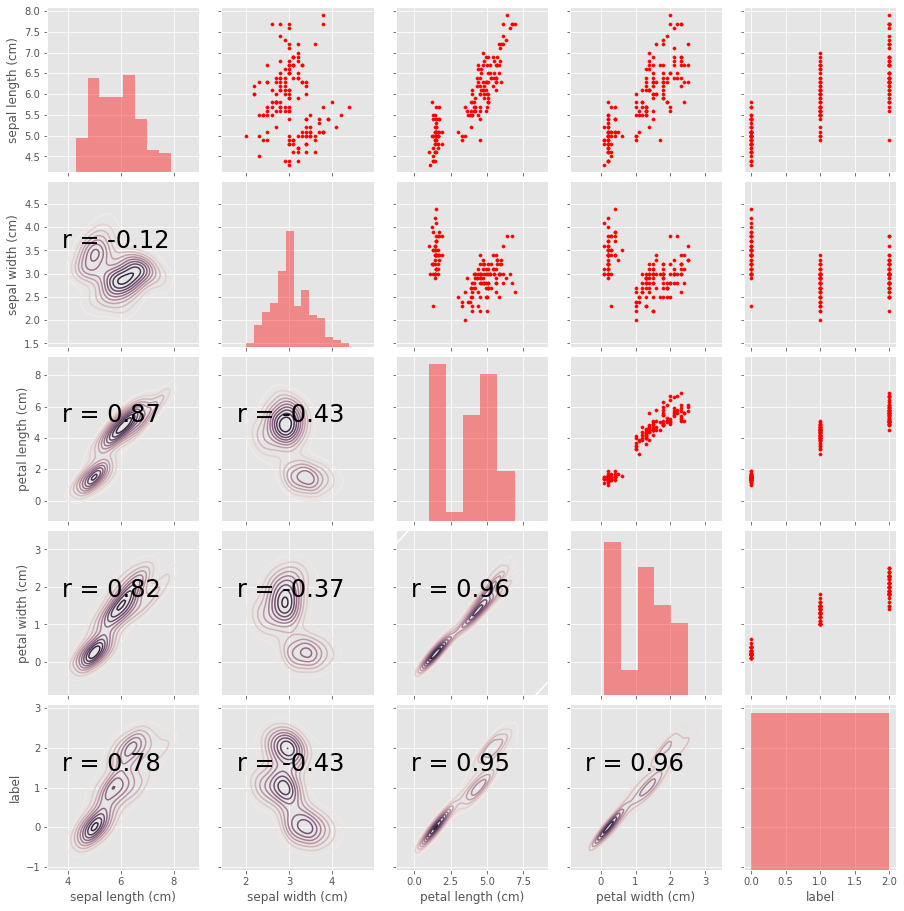

In [125]:
# Step 22

# Generating the pair plot using the seaborn package
import warnings
warnings.filterwarnings('ignore')

# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from scipy import stats

# Calculate correlation coefficient
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

In [108]:
# Step 23

def standardizeData(dataSet):
    for key, values in dataSet.iteritems():
        mean = dataSet[key].mean()
        std = dataSet[key].std()
        if key != 'target':
            dataSet[key] = (dataSet[key] - mean) / std
    return dataSet

standardizeData = standardizeData(df)

In [109]:
# Step 24

# Splitting the data into Train Set and Test Set
def partition(X,y,t):
    x_train = np.array(X[int((len(X)+1)*t):])
    x_test = np.array(X[:int((len(X)+1)*t)])
    y_train = np.array(y[int((len(y)+1)*t):])
    y_test = np.array(y[:int((len(y)+1)*t)]) 
    return x_train, x_test, y_train, y_test

#separate the target vector and features
def separateTargetVector(dataSet):
    y = dataSet['target'] #target vector
    X = dataSet.drop(columns='target') #features matrix
    return X,y

#a function to split data into partition
#according to the number of folds
def partitionSplit(df, folds):
    s_partition = []
    dfCopy = df
    #set the size for each partiton
    eachPartition = int(df.shape[0] / folds)
    for i in range(folds):
        partition = []
        #going through each partition
        for j in range(eachPartition):
            if(len(partition) < eachPartition):
                value = dfCopy.index[0]
                partition.append(value.tolist())
                dfCopy = dfCopy.drop(value)
        s_partition.append((np.asarray(partition)).tolist())
  
    return s_partition

In [110]:
# Step 25

#function for the s-fold validation
def sFold(folds, data, labels, model, error_function, dictionary): 
    avgAccuracy = [] 
    value = []
    splitX = partitionSplit(data, folds)
    minError = 100.0
    
    #loop to choose a partition as validation set
    for i, partition in enumerate(splitX):
        trainSet = list(splitX)
        del(trainSet[i])       #dropping the validation set
        trainSet = sum(trainSet, [])

        testSet = []           #getting the validation set 
        for row in partition:
            testSet.append(row)  #put data in validation set into a new list 
            
        #splitting the data into train and test set
        xTrainValues = []
        yTrainValues = []        
        for trainIndex in trainSet:
            xTrainValues.append(data.loc[trainIndex])
            yTrainValues.append(labels.loc[trainIndex])

        #splitting the validation set data into train and test set
        xTestValues = []
        yTestValues = []
        for testIndex in testSet:
            xTestValues.append(data.loc[testIndex])
            yTestValues.append(labels.loc[testIndex])
    
        #preform prediction using Softmax Regression
        if model == 'Softmax_Regression':
            modelClassifier = Softmax_Regression()
            modelClassifier.fit(np.array(xTrainValues), np.array(yTrainValues), learning_rate = dictionary.get('learning_rate'), epochs=1000, tol = dictionary.get('tol'), regularizer = dictionary.get('regularizer'), lambd = dictionary.get('lambd'), early_stopping=False, validation_fraction=0.1)
            yPredict= modelClassifier.predict(np.array(xTestValues))
            
            #calculating the error using mse score
            if error_function == "accuracy":
                accuracy_value = accuracy(yPredict, np.array(yTestValues))
                avgAccuracy.append(accuracy_value)
                
    avgFinalAccuracy = sum(avgAccuracy)/folds
    if(avgFinalAccuracy < minError):
        minError = avgFinalAccuracy
#         print("Average Accuracy: %.8f" %avgFinalAccuracy)
#         print("Lambda: %.4f" %dictionary.get('lambd'))
#         print("Tol: %.4f" %dictionary.get('tol'))
#         print("Learning Rate: %.4f" %dictionary.get('learning_rate')) 
#         print("Regularizer: %s" %dictionary.get('regularizer'))
#         print("\n")
    return minError
    
    
#function to pass the hyperparameter into s-fold validation
def dictionary(lambd, tol, learning_rate, regularizer):
    result = []
    model = []
    modelArgs = dict()
    #form the dictionary
    for eachLambd in lambd:
        for eachTol in tol:
            for eachLearningRate in learning_rate:
                for eachRegularizer in regularizer:
                    modelArgs = {'lambd' : eachLambd, 'tol' : eachTol, 'learning_rate' : eachLearningRate,'regularizer': eachRegularizer}
                    #use of s-folds
                    accuracy = sFold(5, X, y, 'Softmax_Regression', 'accuracy', modelArgs)
                    result.append(accuracy)
                    model.append(modelArgs)

    acc = np.array(result)
    best_args = model[acc.argmax()]
    return best_args
    
#get the X data(features without target) and y data(target column)
X,y = separateTargetVector(standardizeData)
                
lambd = [0.1,0.01, 0.001, 0.0001]
tol = [0.001, 0.0001, 0.00001, 0.000001, 0.0000001]
learning_rate = [0.1, 0.01, 0.001]
regularizer = ['l1', 'l2']

best_args = dictionary(lambd, tol, learning_rate,regularizer)

In [111]:
print(best_args)

{'lambd': 0.1, 'tol': 0.0001, 'learning_rate': 0.001, 'regularizer': 'l1'}


In [112]:
# Step 26

X,y = separateTargetVector(standardizeData)
xTrain, xTest, yTrain, yTest = partition(X, y, 0.2)
modelClassifier = Softmax_Regression()
modelClassifier.fit(xTrain, yTrain, learning_rate = 0.001, epochs=1000, tol = 0.0001, regularizer = 'l1', lambd = 0.1, early_stopping=False, validation_fraction=0.1)
yPredict = modelClassifier.predict(xTest)
yPredict = np.array(yPredict)

print('Accuracy:', accuracy(yTest, yPredict))
print('Confusion Matrix:', confusionMatrix(yTest, yPredict))
print("\n")

Accuracy: 0.9
Confusion Matrix: [[9. 0. 0.]
 [0. 9. 1.]
 [0. 2. 9.]]


